# Лабораторная работа №2

In [ ]:
# Loading extension for reloading editable packages (pip install -e .)
%load_ext autoreload

In [ ]:
# Reloading editable packages.
%autoreload
# from lab1.main import get_results

Вариант для задания №3:
1. Номер группы + 15 = 2 + 15 = 17
2. Номер варианта + 56 = 14 + 56 = 70
3. ИУ5 (Номер варианта + 21) = 14 + 21 = 35

In [10]:
import pickle
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from numpy.typing import ArrayLike
from PIL import Image
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from tqdm import tqdm

%matplotlib inline

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Классификация изображений CIFAR100
### Загрузка и распаковка набора данных CIFAR100

In [2]:
import os
import shutil
import urllib
from pathlib import Path

url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
filename = "cifar-100-python.tar.gz"
data_path = Path("data")

data_path.mkdir(exist_ok=True)

file_path = data_path / filename

if not os.path.isfile(file_path):
    urllib.request.urlretrieve(url, file_path)
    shutil.unpack_archive(file_path, extract_dir=data_path)
    file_path.unlink()  # Remove archive after extracting it.

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

### Чтение тренировочной и тестовой выборки

In [3]:
def stem_extensions(filename: Path):
    extensions = "".join(filename.suffixes)

    return str(filename).removesuffix(extensions)

In [4]:
dataset_path = Path(stem_extensions(file_path))

with open(dataset_path / "train", "rb") as f:
    data_train = pickle.load(f, encoding="latin1")
with open(dataset_path / "test", "rb") as f:
    data_test = pickle.load(f, encoding="latin1")

# Классы по варианту.
CLASSES = [17, 70, 35]

train_X_raw = data_train["data"].reshape(-1, 3, 32, 32)
train_X_raw = np.transpose(train_X_raw, [0, 2, 3, 1])  # NCHW -> NHWC
train_y_raw = np.array(data_train["fine_labels"])
mask = np.isin(train_y_raw, CLASSES)
train_X = train_X_raw[mask].copy()
train_y = train_y_raw[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test["data"].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test["fine_labels"])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test

# print(train_y_raw.tolist())

In [5]:
def createImage(data: ArrayLike):
    return Image.fromarray(data).resize((256, 256))

In [6]:
# Source: https://stackoverflow.com/a/47334314
def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(10, 10)):
    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns + 1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis("off")
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])

class_id = 17:


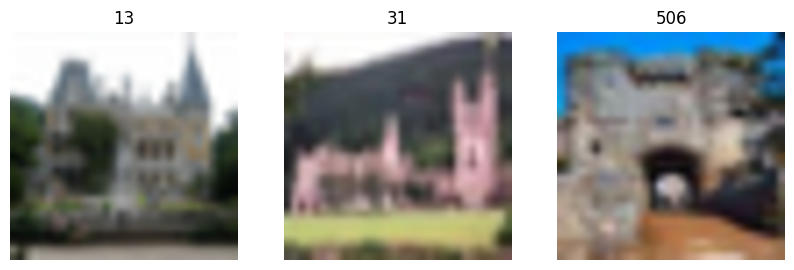

class_id = 70:


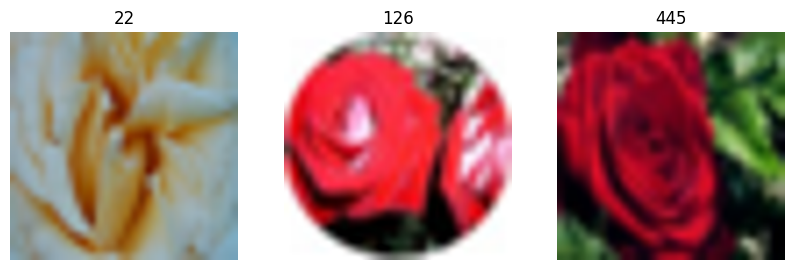

class_id = 35:


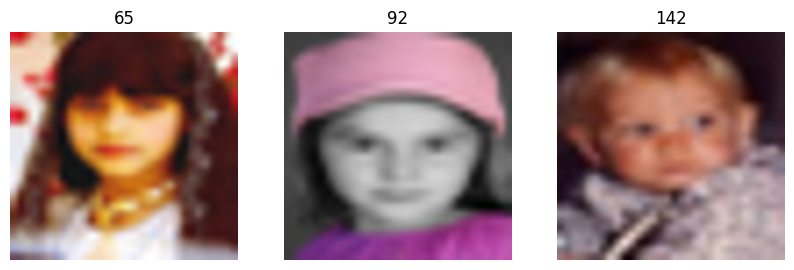

In [7]:
# По 3 экземпляра класса из выборки.
number_of_images_per_class_to_show = 3

for class_id in CLASSES:
    print(f"{class_id = }:")
    i = number_of_images_per_class_to_show
    image_index_for_class = -1
    class_images = []
    image_indices = []

    while i > 0:
        image_index_for_class = train_y_raw.tolist().index(
            class_id, image_index_for_class + 1
        )
        image_indices.append(image_index_for_class)
        class_images.append(createImage(train_X_raw[image_index_for_class]))
        i -= 1
    grid_display(class_images, image_indices, number_of_images_per_class_to_show)
    plt.show()

### Создание Pytorch DataLoader'a

In [11]:
def create_dataloader(batch_size=128):
    dataloader: dict[str, DataLoader] = {}
    for (X, y), part in zip([(train_X, train_y), (test_X, test_y)], ["train", "test"]):
        tensor_x = torch.Tensor(X)
        tensor_y = (
            F.one_hot(torch.Tensor(y).to(torch.int64), num_classes=len(CLASSES)) / 1.0
        )
        dataset = TensorDataset(tensor_x, tensor_y)  # создание объекта датасета
        dataloader[part] = DataLoader(
            dataset, batch_size=batch_size, shuffle=True
        )  # создание экземпляра класса DataLoader

    return dataloader

### Создание Pytorch модели свёрточной нейронной сети

In [23]:
HIDDEN_SIZE = 32


class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return x.permute(0, 3, 1, 2)  # nhwc -> nm


class GlobalMaxPool2d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()

    def forward(self, input):
        out = F.adaptive_max_pool2d(input, output_size=1)
        return out.flatten(start_dim=1)


class Cifar100_CNN(nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, classes=100):
        super(Cifar100_CNN, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.seq = nn.Sequential(
            Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025]),
            # первый способ уменьшения размерности картинки - через stride
            nn.Conv2d(3, hidden_size, 5, stride=4, padding=2),
            nn.ReLU(),
            # второй способ уменьшения размерности картинки - через слой пуллинг
            nn.Conv2d(hidden_size, hidden_size * 2, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(4),  # nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(hidden_size * 8, classes),
        )

    def forward(self, input):
        return self.seq(input)


model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
# NEW
model.to(device)
print(model(torch.rand(1, 32, 32, 3).to(device)))
summary(model, input_size=(32, 32, 3))
model

tensor([[-0.4284,  0.0062,  0.1202]], grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2             [-1, 32, 8, 8]           2,432
              ReLU-3             [-1, 32, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          18,496
              ReLU-5             [-1, 64, 8, 8]               0
         AvgPool2d-6             [-1, 64, 2, 2]               0
           Flatten-7                  [-1, 256]               0
            Linear-8                    [-1, 3]             771
Total params: 21,699
Trainable params: 21,699
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.12
Params size (MB): 0.08
Estimated Total Size (MB): 0.22
---------------------------------------------

Cifar100_CNN(
  (seq): Sequential(
    (0): Normalize()
    (1): Conv2d(3, 32, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=3, bias=True)
  )
)

### Обучение модели по эпохам

In [24]:
EPOCHS = 250


def train(
    model: nn.Module,
    criterion: nn.CrossEntropyLoss,
    optimizer: optim.Optimizer,
    dataloader: dict[str, DataLoader],
    epochs=EPOCHS,
):
    steps_per_epoch = len(dataloader["train"])
    steps_per_epoch_val = len(dataloader["test"])

    for epoch in range(epochs):  # проход по набору данных несколько раз
        running_loss = 0.0
        model.train()
        for i, batch in enumerate(dataloader["train"], 0):
            # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
            inputs, labels = batch

            # очищение прошлых градиентов с прошлой итерации
            optimizer.zero_grad()

            # прямой + обратный проходы + оптимизация
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            # для подсчёта статистик
            running_loss += loss.item()
        print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / steps_per_epoch:.3f}")
        running_loss = 0.0
        model.eval()
        with torch.no_grad():  # отключение автоматического дифференцирования
            for i, data in enumerate(dataloader["test"], 0):
                inputs, labels = data

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
        print(
            f"[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}"
        )
    print("Обучение закончено")

    return dataloader

### Выбор функции потерь и оптимизатора градиентного спуска

In [25]:
def train_classifier(
    model: nn.Module, learning_rate=0.005, batch_size=128, epochs=EPOCHS
):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    dataloader = create_dataloader(batch_size=batch_size)

    return train(
        model,
        criterion=criterion,
        optimizer=optimizer,
        dataloader=dataloader,
        epochs=epochs,
    )


dataloader = train_classifier(model)

[1,    12] loss: 1.098
[1,     3] val loss: 1.085
[2,    12] loss: 1.088
[2,     3] val loss: 1.081
[3,    12] loss: 1.078
[3,     3] val loss: 1.072
[4,    12] loss: 1.069
[4,     3] val loss: 1.061
[5,    12] loss: 1.059
[5,     3] val loss: 1.054
[6,    12] loss: 1.049
[6,     3] val loss: 1.040
[7,    12] loss: 1.038
[7,     3] val loss: 1.031
[8,    12] loss: 1.026
[8,     3] val loss: 1.018
[9,    12] loss: 1.014
[9,     3] val loss: 1.001
[10,    12] loss: 1.000
[10,     3] val loss: 0.989
[11,    12] loss: 0.986
[11,     3] val loss: 0.969
[12,    12] loss: 0.970
[12,     3] val loss: 0.956
[13,    12] loss: 0.954
[13,     3] val loss: 0.927
[14,    12] loss: 0.936
[14,     3] val loss: 0.915
[15,    12] loss: 0.917
[15,     3] val loss: 0.899
[16,    12] loss: 0.896
[16,     3] val loss: 0.891
[17,    12] loss: 0.876
[17,     3] val loss: 0.860
[18,    12] loss: 0.855
[18,     3] val loss: 0.819
[19,    12] loss: 0.836
[19,     3] val loss: 0.824
[20,    12] loss: 0.814
[20,  

[157,    12] loss: 0.392
[157,     3] val loss: 0.381
[158,    12] loss: 0.392
[158,     3] val loss: 0.395
[159,    12] loss: 0.391
[159,     3] val loss: 0.427
[160,    12] loss: 0.392
[160,     3] val loss: 0.420
[161,    12] loss: 0.388
[161,     3] val loss: 0.398
[162,    12] loss: 0.387
[162,     3] val loss: 0.434
[163,    12] loss: 0.392
[163,     3] val loss: 0.409
[164,    12] loss: 0.385
[164,     3] val loss: 0.388
[165,    12] loss: 0.387
[165,     3] val loss: 0.403
[166,    12] loss: 0.386
[166,     3] val loss: 0.399
[167,    12] loss: 0.383
[167,     3] val loss: 0.357
[168,    12] loss: 0.382
[168,     3] val loss: 0.398
[169,    12] loss: 0.381
[169,     3] val loss: 0.361
[170,    12] loss: 0.380
[170,     3] val loss: 0.394
[171,    12] loss: 0.381
[171,     3] val loss: 0.391
[172,    12] loss: 0.381
[172,     3] val loss: 0.391
[173,    12] loss: 0.377
[173,     3] val loss: 0.380
[174,    12] loss: 0.376
[174,     3] val loss: 0.382
[175,    12] loss: 0.380
[17

### Проверка качества модели по классам на обучающей и тестовой выборках

In [ ]:
def report_classification_results(dataloader: DataLoader):
    y_pred = []
    y_true = []
    with torch.no_grad():  # отключение автоматического дифференцирования
        for _, data in enumerate(dataloader, 0):
            inputs, labels = data

            outputs = model(inputs).detach().numpy()
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(
            classification_report(
                y_true.argmax(axis=-1),
                y_pred.argmax(axis=-1),
                digits=4,
                target_names=list(map(str, CLASSES)),
            )
        )

In [ ]:
def compare_classification_reports(dataloader: dict[str, DataLoader]):
    for part in ["train", "test"]:
        print(part)
        report_classification_results(dataloader[part])
        part != "test" and print("-" * 53)


compare_classification_reports(dataloader)

### Анализ результатов обучения модели
Как видно, лучше всего был предсказан класс с идентификатором 17, представляющий
собой замки. Вероятнее всего это связано с количеством общих уникальных черт объектов
на картинках: у замков их намного меньше по сравнению с, например, ребёнком,
который может быть разного возраста, расы и может быть одет по-разному.

На лицо так же переобучение: в обучающей выборке характеристики были почти идеальными,
а в тестовых данных для некоторых классов средними. Скорректируем параметры для устранения
этого феномена в надежде улучшить качество модели.

Уменьшим количество эпох.

In [ ]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=51)
compare_classification_reports(dataloader)

### Визуализация весов

In [ ]:
weights = list(model.parameters())[0].detach().numpy()
print(weights.shape)
fig, ax = plt.subplots(1, weights.shape[0], figsize=(3 * weights.shape[0], 3))
for i, ω in enumerate(weights):
    ω = ω.reshape(32, 32, 3)
    ω -= np.percentile(ω, 1, axis=[0, 1])
    ω /= np.percentile(ω, 99, axis=[0, 1])
    ω = np.clip(ω, 0, 1)
    ax[i].imshow(ω)

По логам потерь было выяснено, что переобучение для данной модели
начинается на 52 эпохах, поэтому оставим 51.

Изменим batch_size, сохраняя общее количество итераций. Для этого количество
эпох уменьшим в то же количество раз, во сколько увеличили batch_size.

In [ ]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=25, batch_size=256)
compare_classification_reports(dataloader)

Общие метрики модели на тестовой выборке не сильно поменялись, однако
отношение значений обучающий к тестовой выборке очень близко к 1. Можно
с уверенностью сказать, что на данном этапе переобучения не наблюдается.

Постараемся ещё улучшить модель:
уменьшим скорость обучения и увеличим общее количество итераций.

Для уменьшенной в два раза скорости обучения, переобучение началось в районе
78-79 эпох. Поставив 77 эпохи мы достигли точности:

In [ ]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, learning_rate=0.0025, epochs=77, batch_size=256)
compare_classification_reports(dataloader)

Поменяем количество нейронов в скрытом слое. Так как модель из-за этого
значительно поменяем, подстроим остальные гиперпараметры для устранения
переобучения и постараемся найти максимум, которого может достигичь модель.

In [ ]:
model = Cifar100_CNN(hidden_size=2 * HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, learning_rate=0.0025, epochs=88, batch_size=256)
compare_classification_reports(dataloader)

Добавим ещё один скрытый слой.

In [ ]:
class Cifar100_CNN_2(nn.Module):
    def __init__(self, hidden_sizes=[32, 26], classes=100):
        super(Cifar100_CNN_2, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.norm = Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025])
        self.seq = nn.Sequential(
            nn.Linear(32 * 32 * 3, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], classes),
        )

    def forward(self, input):
        x = self.norm(input)

        return self.seq(x)

In [ ]:
model = Cifar100_CNN_2(classes=len(CLASSES))
dataloader = train_classifier(model, learning_rate=0.0025, epochs=233, batch_size=256)
compare_classification_reports(dataloader)